In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess

def normalize_model_class_name(model_class_name):
    line1 = model_class_name
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretClassifier_" , "caret.classifier.caret_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretRegressor_" , "caret.regressor.caret_reg_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor_" , "caret.preprocessor.caret_prep_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasClassifier_" , "keras.classifier.keras_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasRegressor_" , "keras.regressor.keras_reg_")
    return line1

def normalize_model_name(model_name):
    line1 = model_name
    line1 = line1.replace("cCaretClassifier_" , "caret_class_")
    line1 = line1.replace("cCaretRegressor_" , "caret_reg_")
    line1 = line1.replace("cCaretPreprocessor_" , "caret_prep_")
    line1 = line1.replace("cKerasClassifier_" , "keras_class_")
    line1 = line1.replace("cKerasRegressor_" , "keras_reg_")
    return line1

database_name_from_dsn = {"pgsql" : "PostgreSQL",
                          "oracle" : "Oracle", 
                          "db2" : "IBM DB2", 
                          "sqltm" : "SQLite",
                          "mssql" : "MS SQL Server",
                          "mysql" : "MariaDB",
                          "hive" : "Apache Hive",
                          "impala" : "Impala",
                          "firebird" : "Firebird",
                          "monetdb" : "MonetDB",
                          "teradata" : "Teradata"}

def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        if(msg_field.startswith("'cTrainingError")):
            msg_field = " ".join(fields[11:-1])
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['dialect'] = df['dialect'].apply(lambda x : strip_punc(x))
    df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
    df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))

    print(list( df['dialect'].unique()))
    df['dialect'] = df['dialect'].apply(database_name_from_dsn.get)
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['Model'] = df['Model'].apply(normalize_model_name)
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    df['error_message'] = df['error_message'].apply(lambda x : x[0:100])
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

['db2', 'firebird', 'monetdb', 'mssql', 'mysql', 'oracle', 'pgsql', 'sqltm', 'teradata']


In [5]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5


In [6]:
df.Model.value_counts()

Perceptron                          162
keras_class_LSTM_pipe               162
DummyClassifier_pipe                162
caret_class_rpart                   162
ExtraTreesClassifier                162
PassiveAggressiveClassifier         162
keras_class_GRU_pipe                162
RidgeClassifierCV_pipe              162
RandomForestClassifier_pipe         162
Perceptron_pipe                     162
LogisticRegression                  162
LinearSVC_pipe                      162
LinearDiscriminantAnalysis_pipe     162
CalibratedClassifierCV_pipe         162
DummyClassifier                     162
DecisionTreeClassifier_pipe         162
keras_class_SimpleRNN               162
RandomForestClassifier              162
keras_class_Dense_pipe              162
OneVsOneClassifier_pipe             162
PassiveAggressiveClassifier_pipe    162
LabelBinarizer                      162
LogisticRegressionCV_pipe           162
keras_class_Dense                   162
OneVsRestClassifier                 162


In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        line1 = normalize_model_class_name(line1)
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'LGBMClassifier': 'lightgbm.sklearn.LGBMClassifier',
 'LGBMRegressor': 'lightgbm.sklearn.LGBMRegressor',
 'cCaretClassifier': 'sklearn2sql.Helpers.Caret_Model.cCaretClassifier',
 'caret_class_ctree': 'caret.classifier.caret_class_ctree',
 'caret_class_ctree2': 'caret.classifier.caret_class_ctree2',
 'caret_class_glm': 'caret.classifier.caret_class_glm',
 'caret_class_glmnet': 'caret.classifier.caret_class_glmnet',
 'caret_class_nnet': 'caret.classifier.caret_class_nnet',
 'caret_class_rf': 'caret.classifier.caret_class_rf',
 'caret_class_rpart': 'caret.classifier.caret_class_rpart',
 'caret_class_svmRadial': 'caret.classifier.caret_class_svmRadial',
 'caret_class_xgbTree': 'caret.classifier.caret_class_xgbTree',
 'cCaretPreprocessor': 'sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor',
 'caret_prep_center_scale': 'caret.preprocessor.caret_prep_center_scale',
 'caret_prep_ica': 'caret.preprocessor.caret_prep_ica',
 'caret_prep_pca': 'caret.preprocessor.caret_prep_pca',
 'cCaretRegres

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4,lightgbm.sklearn
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7,lightgbm.sklearn
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

['IBM DB2' 'Firebird' 'MonetDB' 'MS SQL Server' 'MariaDB' 'Oracle'
 'PostgreSQL' 'SQLite' 'Teradata']
df.shape (21535, 8) Index(['Model', 'dataset', 'dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING Teradata ExtraTreeClassifier_pipe 18 9
MODEL_DATASETS_MISSING Teradata LGBMClassifier 18 11
MODEL_DATASETS_MISSING Teradata LGBMClassifier_pipe 18 12
MODEL_DATASETS_MISSING Teradata MLPClassifier 18 11
MODEL_DATASETS_MISSING Teradata MLPClassifier_pipe 18 11
MODEL_DATASETS_MISSING Teradata NuSVC 18 9
MODEL_DATASETS_MISSING Teradata NuSVC_pipe 18 9
MODEL_DATASETS_MISSING Teradata SVC 18 10
MODEL_DATASETS_MISSING Teradata SVC_pipe 18 9


In [15]:
missing_data.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category
0,caret_class_nnet,DS_BENCH_C_200_82_10_EA8E6ACF,Firebird,no_dsn,failure,TIMEOUT,None,caret.classifier
1,BernoulliNB,DS_BENCH_N_200_22_10_D28EF166,MonetDB,no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
2,BernoulliNB,DS_BENCH_N_50_22_10_D28EF166,MonetDB,no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
3,BernoulliNB,DS_BENCH_N_50_82_2_83B7053C,MonetDB,no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
4,BernoulliNB,DS_BENCH_N_50_82_4_DBD3B4F4,MonetDB,no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(21816, 8)

In [19]:
df.dialect.value_counts()

Teradata         2424
MonetDB          2424
Firebird         2424
MariaDB          2424
PostgreSQL       2424
SQLite           2424
Oracle           2424
IBM DB2          2424
MS SQL Server    2424
Name: dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'error_message' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


error_message
dialect       error_message                                                    
Firebird      'DatabaseError:(fdb.fbcore.DatabaseError)                     245
              "DatabaseError:('Error                                        221
MonetDB       'IntegrityError:COMMIT:                                       204
              "Exception:CODE_GENERATION_NOT_IMPLEMENTED                    176
Teradata      TIMEOUT                                                       154
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  128
MonetDB       TIMEOUT                                                       113
Oracle        "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   84
IBM DB2       "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   69
MariaDB       "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   64
SQLite        "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   59
MS SQL Server "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   59
PostgreSQL    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   58
MonetDB       "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   53
Teradata      'DatabaseError:(teradata.api.DatabaseError)                    51
Firebird      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   44
              "DatabaseError:(fdb.fbcore.DatabaseError)                      41
PostgreSQL    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
MariaDB       "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
IBM DB2       "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
Teradata      "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
MS SQL Server "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
SQLite        "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
Oracle        "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
Firebird      "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
MonetDB       'DBAPIError:(builtins.BrokenPipeError)                         21
MS SQL Server 8115, b'Arithmetic overflow error converting ex...             20
              125, b'Case expressions may only be nested to l...             17
Teradata      "cTrainingError:Exception:TRAIN_FAILED                         14
PostgreSQL    ) value out of range: overflo                                  13
...                                                                         ...
MariaDB       1690, "DOUBLE value is out of range in 'exp(-(g...              1
Firebird      "Exception:PREDICT_FAILED                                       1
              'IndexError:list                                                1
              'cTrainingError:ValueError:`min_samples` may no...              1
              TIMEOUT                                                         1
IBM DB2       'DBAPIError:(ibm_db_dbi.Error)                                  1
              'cTrainingError:ValueError:`min_samples` may no...              1
MS SQL Server 'cTrainingError:ValueError:`min_samples` may no...              1
MariaDB       "FileNotFoundError:File                                         1
              'cTrainingError:ValueError:`min_samples` may no...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
MonetDB       "FileNotFoundError:File                                         1
MariaDB       1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...  

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,19432
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",618
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",464
TIMEOUT,281
'DatabaseError:(fdb.fbcore.DatabaseError),245
"""DatabaseError:('Error",221
'IntegrityError:COMMIT:,204
'DatabaseError:(teradata.api.DatabaseError),51
"""cTrainingError:Exception:TRAIN_FAILED",48
"""DatabaseError:(fdb.fbcore.DatabaseError)",41


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
lComparisonErrorMessage = '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS'
real_errors = df[df.error_message.str.contains(lComparisonErrorMessage)]
real_errors.Model.value_counts()

caret_class_svmRadial              90
DummyClassifier                    54
DummyClassifier_pipe               53
keras_class_SimpleRNN_pipe         51
caret_class_nnet                   50
caret_class_xgbTree                49
keras_class_SimpleRNN              47
ExtraTreesClassifier_pipe          28
OrdinalEncoder                     26
ComplementNB_pipe                  18
ComplementNB                       18
FastICA                            16
LinearDiscriminantAnalysis_pipe    14
FactorAnalysis                     12
caret_class_rf                     10
ExtraTreesClassifier               10
ExtraTreeClassifier_pipe            9
AdaBoostClassifier_pipe             9
XGBRegressor                        8
QuantileTransformer                 5
AdaBoostClassifier                  5
BaggingClassifier                   5
RandomForestClassifier              4
ExtraTreeClassifier                 4
LGBMClassifier_pipe                 4
RandomForestClassifier_pipe         3
BaggingClass

In [27]:
lNotImplementedMessage = 'CODE_GENERATION_NOT_IMPLEMENTED'

not_impl_errors = df[df.error_message.str.contains(lNotImplementedMessage)]
not_impl_errors.Model.value_counts()


SparsePCA                     108
MiniBatchSparsePCA            108
NMF                            54
LatentDirichletAllocation      54
keras_class_GRU_pipe           18
keras_class_GRU                18
keras_class_LSTM_pipe          18
keras_class_SimpleRNN          18
keras_class_SimpleRNN_pipe     18
keras_class_LSTM               17
keras_reg_GRU_pipe              6
keras_reg_LSTM_pipe             6
keras_reg_GRU                   6
keras_reg_LSTM                  6
keras_reg_SimpleRNN_pipe        5
keras_reg_SimpleRNN             4
Name: Model, dtype: int64

In [28]:
# database related errors
def is_other_error(x):
    lKnownError = 'SUCCESS' in [x] or lComparisonErrorMessage in [x] or lNotImplementedMessage in [x]
    return not lKnownError

# other_errors = df.error_message.apply(lambda x : 1 if is_other_error(x)  else 0)
other_errors = df[df.error_message.apply(is_other_error)]
other_errors.Model.value_counts()


MiniBatchSparsePCA                  108
SparsePCA                           108
keras_class_LSTM_pipe                58
keras_class_LSTM                     56
LatentDirichletAllocation            54
NMF                                  54
SVC                                  39
NuSVC                                37
SVC_pipe                             31
NuSVC_pipe                           30
MLPClassifier_pipe                   29
LGBMClassifier                       28
LGBMClassifier_pipe                  28
AdaBoostClassifier_pipe              27
caret_class_svmRadial                25
MLPClassifier                        25
caret_class_glmnet                   24
GaussianNB                           24
caret_class_nnet                     24
keras_class_SimpleRNN                23
keras_class_GRU_pipe                 23
QuantileTransformer                  23
AdaBoostClassifier                   22
keras_class_GRU                      22
keras_class_SimpleRNN_pipe           22


In [29]:
# df.pivot(index = 'Model', values='status' , columns='dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4,lightgbm.sklearn
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7,lightgbm.sklearn
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:

df = df[df['model_category'] != 'sklearn.dummy']
df = df[~df['error_message'].str.contains(lNotImplementedMessage)]



In [34]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category,status_2
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,11,lightgbm.sklearn,1
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,4,lightgbm.sklearn,1
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,7,lightgbm.sklearn,1
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,15,lightgbm.sklearn,1
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,5,lightgbm.sklearn,1


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                        \
dialect                       Firebird IBM DB2 MS SQL Server MariaDB MonetDB   
model_category                                                                 
caret.classifier                   150     150           150     150     150   
caret.preprocessor                  36      36            36      36      36   
caret.regressor                     54      54            54      54      54   
keras.classifier                   144     144           144     144      37   
keras.regressor                     48      48            48      48      15   
lightgbm.sklearn                    48      48            48      48      48   
sklearn.calibration                 36      36            36      36      36   
sklearn.covariance                  12      12            12      12      12   
sklearn.decomposition               72      72            72      72      72   
sklearn.discriminant_analysis       36      36            36      36      36   
sklearn.ensemble                   252     252           252     252     252   
sklearn.feature_selection          108     108           108     108     108   
sklearn.impute                      24      24            24      24      24   
sklearn.kernel_ridge                12      12            12      12      12   
sklearn.linear_model               492     492           492     492     492   
sklearn.multiclass                  72      72            72      72      72   
sklearn.naive_bayes                144     144           144     144     144   
sklearn.neural_network              48      48            48      48      48   
sklearn.pipeline                    48      48            48      48      48   
sklearn.preprocessing              180     180           180     180     180   
sklearn.random_projection           24      24            24      24      24   
sklearn.svm                        156     156           156     156     156   
sklearn.tree                        96      96            96      96      96   
xgboost.sklearn                     48      48            48      48      48   
All                               2340    2340          2340    2340    2200   

                                                                        
dialect                       Oracle PostgreSQL SQLite Teradata    All  
model_category                                                          
caret.classifier                 150        150    150      150   1350  
caret.preprocessor                36         36     36       36    324  
caret.regressor                   54         54     54       54    486  
keras.classifier                 144        144    144      144   1189  
keras.regressor                   48         48     48       48    399  
lightgbm.sklearn                  48         48     48       48    432  
sklearn.calibration               36         36     36       36    324  
sklearn.covariance                12         12     12       12    108  
sklearn.decomposition             72         72     72       72    648  
sklearn.discriminant_analysis     36         36     36       36    324  
sklearn.ensemble                 252        252    252      252   2268  
sklearn.feature_selection        108        108    108      108    972  
sklearn.impute                    24         24     24       24    216  
sklearn.kernel_ridge              12         12     12       12    108  
sklearn.linear_model             492        492    492      492   4428  
sklearn.multiclass                72         72     72       72    648  
sklearn.naive_bayes              144        144    144      144   1296  
sklearn.neural_network            48         48     48       48    432  
sklearn.pipeline                  48         48     48       48    432  
sklearn.preprocessing            180        180    180      180   1620  
sklearn.random_projection         24         24     24       24    216  
sklearn.svm                      156      

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                    \
dialect                        Firebird   IBM DB2 MS SQL Server   MariaDB   
model_category                                                              
caret.classifier               0.386667  0.186667      0.226667  0.200000   
caret.preprocessor             0.111111  0.000000      0.000000  0.000000   
caret.regressor                0.166667  0.037037      0.055556  0.000000   
keras.classifier               0.291667  0.090278      0.236111  0.229167   
keras.regressor                0.083333  0.041667      0.041667  0.041667   
lightgbm.sklearn               0.562500  0.020833      0.000000  0.020833   
sklearn.calibration            0.166667  0.000000      0.000000  0.000000   
sklearn.covariance             0.333333  0.166667      0.166667  0.166667   
sklearn.decomposition          0.222222  0.041667      0.027778  0.027778   
sklearn.discriminant_analysis  0.083333  0.055556      0.027778  0.055556   
sklearn.ensemble               0.424603  0.011905      0.007937  0.007937   
sklearn.feature_selection      0.000000  0.000000      0.000000  0.000000   
sklearn.impute                 0.000000  0.000000      0.000000  0.000000   
sklearn.kernel_ridge           0.750000  0.000000      0.000000  0.000000   
sklearn.linear_model           0.032520  0.002033      0.002033  0.002033   
sklearn.multiclass             0.430556  0.000000      0.000000  0.000000   
sklearn.naive_bayes            0.423611  0.041667      0.027778  0.027778   
sklearn.neural_network         0.354167  0.000000      0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000      0.000000  0.000000   
sklearn.preprocessing          0.111111  0.088889      0.033333  0.033333   
sklearn.random_projection      0.166667  0.000000      0.000000  0.000000   
sklearn.svm                    0.544872  0.000000      0.012821  0.000000   
sklearn.tree                   0.010417  0.000000      0.000000  0.000000   
xgboost.sklearn                0.541667  0.020833      0.020833  0.020833   
All                            0.235043  0.034188      0.040171  0.036752   

                                                                        \
dialect                         MonetDB    Oracle PostgreSQL    SQLite   
model_category                                                           
caret.classifier               0.313333  0.200000   0.166667  0.246667   
caret.preprocessor             0.000000  0.000000   0.000000  0.000000   
caret.regressor                0.129630  0.000000   0.055556  0.055556   
keras.classifier               0.108108  0.097222   0.229167  0.097222   
keras.regressor                0.266667  0.083333   0.062500  0.083333   
lightgbm.sklearn               0.291667  0.020833   0.000000  0.000000   
sklearn.calibration            0.138889  0.000000   0.000000  0.000000   
sklearn.covariance             0.250000  0.083333   0.166667  0.166667   
sklearn.decomposition          0.194444  0.027778   0.027778  0.027778   
sklearn.discriminant_analysis  0.083333  0.055556   0.027778  0.027778   
sklearn.ensemble               0.337302  0.007937   0.007937  0.007937   
sklearn.feature_selection      0.000000  0.000000   0.000000  0.000000   
sklearn.impute                 0.000000  0.000000   0.000000  0.000000   
sklearn.kernel_ridge           0.083333  0.000000   0.000000  0.000000   
sklearn.linear_model           0.044715  0.002033   0.002033  0.002033   
sklearn.multiclass             0.263889  0.000000   0.000000  0.000000   
sklearn.naive_bayes            0.562500  0.027778   0.027778  0.027778   
sklearn.neural_network         0.520833  0.000000   0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000   0.000000  0.000000   
sklearn.preprocessing          0.072222  0.033333   0.022222  0.077778   
sklearn.random_projection      0.000000  0.000000   0.000000  0.000000   
sklearn.svm                    0.230769  0.012821   0.000000  0.000000   
sklearn.tree                

In [38]:
df.to_csv('report_extensive_tests.csv')

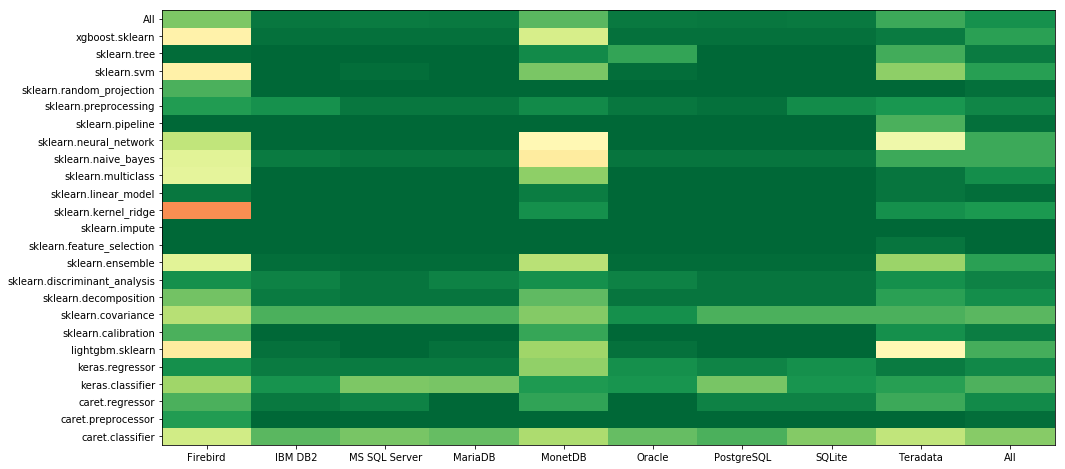

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn' , vmin=0 , vmax=1)
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'caret.classifier', 'caret.preprocessor',
       'caret.regressor', 'keras.classifier', 'keras.regressor',
       'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection', 'sklearn.impute',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.random_projection',
       'sklearn.svm', 'sklearn.tree', 'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
dialect       error_message                                              
Firebird      "DatabaseError:('Error                                   21
              SUCCESS                                                  21
              'DatabaseError:(fdb.fbcore.DatabaseError)                 6
IBM DB2       SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MS SQL Server SUCCESS                                                  48
MariaDB       SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MonetDB       SUCCESS                                                  34
              'IntegrityError:COMMIT:                                   9
              'DBAPIError:(builtins.BrokenPipeError)                    4
              TIMEOUT                                                   1
Oracle        SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
PostgreSQL    SUCCESS                                                  48
SQLite        SUCCESS                                                  48
Teradata      SUCCESS                                                  23
              TIMEOUT                                                  23
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                              \
dialect              Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                       
LGBMClassifier       0.666667  0.000000           0.0  0.000000  0.277778   
LGBMClassifier_pipe  0.555556  0.055556           0.0  0.055556  0.333333   
LGBMRegressor        0.500000  0.000000           0.0  0.000000  0.166667   
LGBMRegressor_pipe   0.333333  0.000000           0.0  0.000000  0.333333   
All                  0.562500  0.020833           0.0  0.020833  0.291667   

                                                                     
dialect                Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                
LGBMClassifier       0.000000        0.0    0.0  0.611111  0.172840  
LGBMClassifier_pipe  0.055556        0.0    0.0  0.722222  0.197531  
LGBMRegressor        0.000000        0.0    0.0  0.000000  0.074074  
LGBMRegressor_pipe   0.000000        0.0    0.0  0.166667  0.092593  
All                  0.020833        0.0    0.0  0.520833  0.159722

ERROR_REPORT_FOR_CATEGORY caret.classifier


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        92
              'DatabaseError:(fdb.fbcore.DatabaseError)                      30
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
              "DatabaseError:('Error                                          7
              "cTrainingError:Exception:TRAIN_FAILED                          4
              "DatabaseError:(fdb.fbcore.DatabaseError)                       3
              'IndexError:list                                                1
              TIMEOUT                                                         1
IBM DB2       SUCCESS                                                       122
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   24
              "cTrainingError:Exception:TRAIN_FAILED                          4
MS SQL Server SUCCESS                                                       116
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   24
              125, b'Case expressions may only be nested to l...              8
              701, b"There is insufficient system memory in r...              2
MariaDB       SUCCESS                                                       120
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   22
              TIMEOUT                                                         7
              "FileNotFoundError:File                                         1
MonetDB       SUCCESS                                                       103
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   18
              TIMEOUT                                                        14
              "cTrainingError:Exception:TRAIN_FAILED                          5
              'IntegrityError:COMMIT:                                         4
              'DBAPIError:(builtins.BrokenPipeError)                          3
              'IndexError:list                                                2
              "FileNotFoundError:File                                         1
Oracle        SUCCESS                                                       120
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   26
              "cTrainingError:Exception:TRAIN_FAILED                          2
              TIMEOUT                                                         2
PostgreSQL    SUCCESS                                                       125
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   24
              'IndexError:list                                                1
SQLite        SUCCESS                                                       113
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   24
              "cTrainingError:Exception:TRAIN_FAILED                         10
              'IndexError:list                                                2
              "KeyError:'NEUR_2_5'"),                                         1
Teradata      SUCCESS                                                        97
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   30
              "cTrainingError:Exception:TRAIN_FAILED                         11
              TIMEOUT                                                         7
              'DatabaseError:(teradata.api.DatabaseError)                     4
              "KeyError:'NEUR_2_5'"),                                         1

mean                                              \
dialect                Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                         
caret_class_ctree      0.111111  0.222222      0.000000  0.000000  0.222222   
caret_class_ctree2     0.000000  0.000000      0.000000  0.000000  0.055556   
caret_class_glm        0.333333  0.000000      0.000000  0.000000  0.000000   
caret_class_glmnet     0.333333  0.000000      0.111111  0.055556  0.333333   
caret_class_nnet       0.722222  0.333333      0.333333  0.555556  0.666667   
caret_class_rf         0.222222  0.000000      0.444444  0.055556  0.055556   
caret_class_rpart      0.055556  0.000000      0.000000  0.000000  0.055556   
caret_class_svmRadial  1.000000  0.666667      0.666667  0.666667  0.666667   
caret_class_xgbTree    0.666667  0.333333      0.333333  0.333333  0.555556   
All                    0.386667  0.186667      0.226667  0.200000  0.313333   

                                                                          
dialect                  Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                     
caret_class_ctree      0.111111   0.000000  0.166667  0.000000  0.092593  
caret_class_ctree2     0.111111   0.000000  0.166667  0.000000  0.037037  
caret_class_glm        0.000000   0.000000  0.000000  0.000000  0.037037  
caret_class_glmnet     0.000000   0.000000  0.000000  0.500000  0.148148  
caret_class_nnet       0.388889   0.333333  0.388889  0.388889  0.456790  
caret_class_rf         0.000000   0.000000  0.111111  0.611111  0.166667  
caret_class_rpart      0.055556   0.055556  0.222222  0.166667  0.067901  
caret_class_svmRadial  0.666667   0.666667  0.666667  0.722222  0.709877  
caret_class_xgbTree    0.333333   0.333333  0.333333  0.555556  0.419753  
All                    0.200000   0.166667  0.246667  0.353333  0.253333

ERROR_REPORT_FOR_CATEGORY caret.preprocessor


error_message
dialect       error_message                                           
Firebird      SUCCESS                                               32
              'DatabaseError:(fdb.fbcore.DatabaseError)              4
IBM DB2       SUCCESS                                               36
MS SQL Server SUCCESS                                               36
MariaDB       SUCCESS                                               36
MonetDB       SUCCESS                                               36
Oracle        SUCCESS                                               36
PostgreSQL    SUCCESS                                               36
SQLite        SUCCESS                                               36
Teradata      SUCCESS                                               36

mean                                        \
dialect                  Firebird IBM DB2 MS SQL Server MariaDB MonetDB   
Model                                                                     
caret_prep_center_scale  0.000000     0.0           0.0     0.0     0.0   
caret_prep_ica           0.000000     0.0           0.0     0.0     0.0   
caret_prep_pca           0.333333     0.0           0.0     0.0     0.0   
All                      0.111111     0.0           0.0     0.0     0.0   

                                                                     
dialect                 Oracle PostgreSQL SQLite Teradata       All  
Model                                                                
caret_prep_center_scale    0.0        0.0    0.0      0.0  0.000000  
caret_prep_ica             0.0        0.0    0.0      0.0  0.000000  
caret_prep_pca             0.0        0.0    0.0      0.0  0.037037  
All                        0.0        0.0    0.0      0.0  0.012346

ERROR_REPORT_FOR_CATEGORY caret.regressor


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        45
              "DatabaseError:('Error                                          3
              'DatabaseError:(fdb.fbcore.DatabaseError)                       3
              "DatabaseError:(fdb.fbcore.DatabaseError)                       2
              "Exception:PREDICT_FAILED                                       1
IBM DB2       SUCCESS                                                        52
              "cTrainingError:Exception:TRAIN_FAILED                          2
MS SQL Server SUCCESS                                                        51
              125, b'Case expressions may only be nested to l...              3
MariaDB       SUCCESS                                                        54
MonetDB       SUCCESS                                                        47
              "Exception:PREDICT_FAILED                                       3
              "cTrainingError:Exception:TRAIN_FAILED                          2
              'IndexError:list                                                1
              'IntegrityError:COMMIT:                                         1
Oracle        SUCCESS                                                        54
PostgreSQL    SUCCESS                                                        51
              "cTrainingError:Exception:TRAIN_FAILED                          2
              "Exception:PREDICT_FAILED                                       1
SQLite        SUCCESS                                                        51
              "cTrainingError:Exception:TRAIN_FAILED                          3
Teradata      SUCCESS                                                        46
              'DatabaseError:(teradata.api.DatabaseError)                     4
              "cTrainingError:Exception:TRAIN_FAILED                          3
              "KeyError:'XD_6'"),                                             1

mean                                            \
dialect              Firebird   IBM DB2 MS SQL Server MariaDB   MonetDB   
Model                                                                     
caret_reg_ctree      0.000000  0.000000      0.000000     0.0  0.333333   
caret_reg_ctree2     0.000000  0.000000      0.000000     0.0  0.166667   
caret_reg_glm        0.000000  0.000000      0.000000     0.0  0.000000   
caret_reg_glmnet     0.000000  0.333333      0.000000     0.0  0.000000   
caret_reg_nnet       0.000000  0.000000      0.000000     0.0  0.166667   
caret_reg_rf         0.333333  0.000000      0.500000     0.0  0.166667   
caret_reg_rpart      0.000000  0.000000      0.000000     0.0  0.000000   
caret_reg_svmRadial  0.833333  0.000000      0.000000     0.0  0.166667   
caret_reg_xgbTree    0.333333  0.000000      0.000000     0.0  0.166667   
All                  0.166667  0.037037      0.055556     0.0  0.129630   

                                                                     
dialect             Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                
caret_reg_ctree        0.0   0.000000  0.000000  0.000000  0.037037  
caret_reg_ctree2       0.0   0.000000  0.000000  0.000000  0.018519  
caret_reg_glm          0.0   0.000000  0.000000  0.000000  0.000000  
caret_reg_glmnet       0.0   0.333333  0.000000  0.166667  0.092593  
caret_reg_nnet         0.0   0.000000  0.000000  0.000000  0.018519  
caret_reg_rf           0.0   0.000000  0.000000  0.500000  0.166667  
caret_reg_rpart        0.0   0.166667  0.000000  0.000000  0.018519  
caret_reg_svmRadial    0.0   0.000000  0.000000  0.666667  0.185185  
caret_reg_xgbTree      0.0   0.000000  0.500000  0.000000  0.111111  
All                    0.0   0.055556  0.055556  0.148148  0.072016

ERROR_REPORT_FOR_CATEGORY keras.classifier


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       102
              "DatabaseError:('Error                                         30
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   11
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
IBM DB2       SUCCESS                                                       131
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
MS SQL Server SUCCESS                                                       110
              8115, b'Arithmetic overflow error converting ex...             20
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   13
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
MariaDB       SUCCESS                                                       111
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(-(g...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
              1690, "DOUBLE value is out of range in 'exp(gre...              1
MonetDB       SUCCESS                                                        33
              'IntegrityError:COMMIT:                                         2
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
              "Exception:CONNECTION_FAILED_WITH_ERROR                         1
Oracle        SUCCESS                                                       130
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   13
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
PostgreSQL    SUCCESS                                                       111
              ) value out of range: overflo                                  13
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
              ) value out of range: underflo                                  7
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
SQLite        SUCCESS                                                       130
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   13
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',       

mean                                    \
dialect                     Firebird   IBM DB2 MS SQL Server   MariaDB   
Model                                                                    
keras_class_Dense           0.166667  0.000000      0.000000  0.000000   
keras_class_Dense_pipe      0.111111  0.000000      0.000000  0.000000   
keras_class_GRU             0.222222  0.000000      0.000000  0.000000   
keras_class_GRU_pipe        0.222222  0.000000      0.000000  0.000000   
keras_class_LSTM            0.222222  0.055556      0.555556  0.555556   
keras_class_LSTM_pipe       0.333333  0.000000      0.611111  0.611111   
keras_class_SimpleRNN       0.555556  0.333333      0.333333  0.333333   
keras_class_SimpleRNN_pipe  0.500000  0.333333      0.388889  0.333333   
All                         0.291667  0.090278      0.236111  0.229167   

                                                                               \
dialect                      MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                           
keras_class_Dense           0.000000  0.000000   0.000000  0.000000  0.000000   
keras_class_Dense_pipe      0.166667  0.000000   0.000000  0.000000  0.055556   
keras_class_GRU                  NaN  0.000000   0.000000  0.000000  0.000000   
keras_class_GRU_pipe             NaN  0.000000   0.000000  0.000000  0.055556   
keras_class_LSTM            1.000000  0.055556   0.555556  0.055556  0.055556   
keras_class_LSTM_pipe            NaN  0.000000   0.611111  0.000000  0.055556   
keras_class_SimpleRNN            NaN  0.333333   0.333333  0.333333  0.333333   
keras_class_SimpleRNN_pipe       NaN  0.388889   0.333333  0.388889  0.388889   
All                         0.108108  0.097222   0.229167  0.097222  0.118056   

                                      
dialect                          All  
Model                                 
keras_class_Dense           0.018519  
keras_class_Dense_pipe      0.037037  
keras_class_GRU             0.027778  
keras_class_GRU_pipe        0.034722  
keras_class_LSTM            0.268966  
keras_class_LSTM_pipe       0.277778  
keras_class_SimpleRNN       0.361111  
keras_class_SimpleRNN_pipe  0.381944  
All                         0.171573

ERROR_REPORT_FOR_CATEGORY keras.regressor


error_message
dialect       error_message                                               
Firebird      SUCCESS                                                   44
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
              "DatabaseError:('Error                                     1
IBM DB2       SUCCESS                                                   46
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              1
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               1
MS SQL Server SUCCESS                                                   46
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              2
MariaDB       SUCCESS                                                   46
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              2
MonetDB       SUCCESS                                                   11
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
              'IntegrityError:COMMIT:                                    1
Oracle        SUCCESS                                                   44
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               1
PostgreSQL    SUCCESS                                                   45
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
SQLite        SUCCESS                                                   44
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              4
Teradata      SUCCESS                                                   46
              "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              2

mean                                    \
dialect                   Firebird   IBM DB2 MS SQL Server   MariaDB   
Model                                                                  
keras_reg_Dense           0.000000  0.000000      0.000000  0.000000   
keras_reg_Dense_pipe      0.000000  0.000000      0.000000  0.000000   
keras_reg_GRU             0.000000  0.000000      0.000000  0.000000   
keras_reg_GRU_pipe        0.000000  0.000000      0.000000  0.000000   
keras_reg_LSTM            0.000000  0.000000      0.000000  0.000000   
keras_reg_LSTM_pipe       0.000000  0.166667      0.000000  0.000000   
keras_reg_SimpleRNN       0.333333  0.000000      0.166667  0.166667   
keras_reg_SimpleRNN_pipe  0.333333  0.166667      0.166667  0.166667   
All                       0.083333  0.041667      0.041667  0.041667   

                                                                             \
dialect                    MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                         
keras_reg_Dense           0.000000  0.000000   0.000000  0.000000  0.000000   
keras_reg_Dense_pipe      0.166667  0.000000   0.000000  0.000000  0.000000   
keras_reg_GRU                  NaN  0.000000   0.000000  0.000000  0.000000   
keras_reg_GRU_pipe             NaN  0.000000   0.000000  0.000000  0.000000   
keras_reg_LSTM                 NaN  0.000000   0.000000  0.000000  0.000000   
keras_reg_LSTM_pipe            NaN  0.166667   0.000000  0.000000  0.000000   
keras_reg_SimpleRNN       1.000000  0.333333   0.166667  0.500000  0.166667   
keras_reg_SimpleRNN_pipe  1.000000  0.166667   0.333333  0.166667  0.166667   
All                       0.266667  0.083333   0.062500  0.083333  0.041667   

                                    
dialect                        All  
Model                               
keras_reg_Dense           0.000000  
keras_reg_Dense_pipe      0.018519  
keras_reg_GRU             0.000000  
keras_reg_GRU_pipe        0.000000  
keras_reg_LSTM            0.000000  
keras_reg_LSTM_pipe       0.041667  
keras_reg_SimpleRNN       0.260000  
keras_reg_SimpleRNN_pipe  0.224490  
All                       0.067669

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
dialect       error_message                                              
Firebird      SUCCESS                                                  30
              "DatabaseError:('Error                                    6
IBM DB2       SUCCESS                                                  36
MS SQL Server SUCCESS                                                  36
MariaDB       SUCCESS                                                  36
MonetDB       SUCCESS                                                  31
              'IntegrityError:COMMIT:                                   5
Oracle        SUCCESS                                                  36
PostgreSQL    SUCCESS                                                  36
SQLite        SUCCESS                                                  36
Teradata      SUCCESS                                                  33
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                          \
dialect                      Firebird IBM DB2 MS SQL Server MariaDB   MonetDB   
Model                                                                           
CalibratedClassifierCV       0.222222     0.0           0.0     0.0  0.111111   
CalibratedClassifierCV_pipe  0.111111     0.0           0.0     0.0  0.166667   
All                          0.166667     0.0           0.0     0.0  0.138889   

                                                                         
dialect                     Oracle PostgreSQL SQLite  Teradata      All  
Model                                                                    
CalibratedClassifierCV         0.0        0.0    0.0  0.055556  0.04321  
CalibratedClassifierCV_pipe    0.0        0.0    0.0  0.111111  0.04321  
All                            0.0        0.0    0.0  0.083333  0.04321

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                         8
              "DatabaseError:('Error                                          2
              'DatabaseError:(fdb.fbcore.DatabaseError)                       2
IBM DB2       SUCCESS                                                        10
              'InternalError:(ibm_db_dbi.InternalError)                       2
MS SQL Server SUCCESS                                                        10
              8631, b'Internal error: Server stack limit has ...              2
MariaDB       SUCCESS                                                        10
              1436, "Thread stack overrun:  1238176 bytes use...              2
MonetDB       SUCCESS                                                         9
              TIMEOUT                                                         2
              'IntegrityError:COMMIT:                                         1
Oracle        SUCCESS                                                        11
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
PostgreSQL    SUCCESS                                                        10
              ) stack depth limit exceededHINT:  Increase the...              2
SQLite        SUCCESS                                                        10
              ) Expression tree is too large (maximum depth 1000              2
Teradata      SUCCESS                                                        10
              'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                              \
dialect                Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                         
EllipticEnvelope       0.333333  0.333333      0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.333333  0.000000      0.000000  0.000000  0.166667   
All                    0.333333  0.166667      0.166667  0.166667  0.250000   

                                                                          
dialect                  Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                     
EllipticEnvelope       0.166667   0.333333  0.333333  0.333333  0.314815  
EllipticEnvelope_pipe  0.000000   0.000000  0.000000  0.000000  0.055556  
All                    0.083333   0.166667  0.166667  0.166667  0.185185

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
dialect       error_message                                              
Firebird      SUCCESS                                                  56
              'DatabaseError:(fdb.fbcore.DatabaseError)                12
              "DatabaseError:(fdb.fbcore.DatabaseError)                 4
IBM DB2       SUCCESS                                                  69
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              'DBAPIError:(ibm_db_dbi.Error)                            1
MS SQL Server SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MariaDB       SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MonetDB       SUCCESS                                                  58
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             14
Oracle        SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
PostgreSQL    SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
SQLite        SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
Teradata      SUCCESS                                                  63
              'DatabaseError:(teradata.api.DatabaseError)               6
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              TIMEOUT                                                   1

mean                                              \
dialect         Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                  
FactorAnalysis  0.000000  0.000000      0.000000  0.000000  1.000000   
FastICA         0.333333  0.166667      0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000      0.000000  0.000000  0.000000   
KernelPCA       1.000000  0.083333      0.000000  0.000000  0.000000   
PCA             0.000000  0.000000      0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.000000      0.000000  0.000000  0.000000   
All             0.222222  0.041667      0.027778  0.027778  0.194444   

                                                                  
dialect           Oracle PostgreSQL    SQLite Teradata       All  
Model                                                             
FactorAnalysis  0.000000   0.000000  0.000000    0.000  0.111111  
FastICA         0.166667   0.166667  0.166667    0.250  0.194444  
IncrementalPCA  0.000000   0.000000  0.000000    0.000  0.000000  
KernelPCA       0.000000   0.000000  0.000000    0.500  0.175926  
PCA             0.000000   0.000000  0.000000    0.000  0.000000  
TruncatedSVD    0.000000   0.000000  0.000000    0.000  0.000000  
All             0.027778   0.027778  0.027778    0.125  0.080247

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
dialect       error_message                                              
Firebird      SUCCESS                                                  33
              'DatabaseError:(fdb.fbcore.DatabaseError)                 2
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
IBM DB2       SUCCESS                                                  34
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MS SQL Server SUCCESS                                                  35
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MariaDB       SUCCESS                                                  34
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MonetDB       SUCCESS                                                  33
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              'IntegrityError:COMMIT:                                   1
Oracle        SUCCESS                                                  34
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
PostgreSQL    SUCCESS                                                  35
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
SQLite        SUCCESS                                                  35
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
Teradata      SUCCESS                                                  33
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                    \
dialect                          Firebird   IBM DB2 MS SQL Server   MariaDB   
Model                                                                         
LinearDiscriminantAnalysis       0.111111  0.000000      0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.055556  0.111111      0.055556  0.111111   
All                              0.083333  0.055556      0.027778  0.055556   

                                                                          \
dialect                           MonetDB    Oracle PostgreSQL    SQLite   
Model                                                                      
LinearDiscriminantAnalysis       0.000000  0.000000   0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.166667  0.111111   0.055556  0.055556   
All                              0.083333  0.055556   0.027778  0.027778   

                                                     
dialect                          Teradata       All  
Model                                                
LinearDiscriminantAnalysis       0.000000  0.012346  
LinearDiscriminantAnalysis_pipe  0.166667  0.098765  
All                              0.083333  0.055556

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
dialect       error_message                                              
Firebird      SUCCESS                                                 145
              "DatabaseError:('Error                                   72
              'DatabaseError:(fdb.fbcore.DatabaseError)                34
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
IBM DB2       SUCCESS                                                 249
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
MS SQL Server SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MariaDB       SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MonetDB       SUCCESS                                                 167
              'IntegrityError:COMMIT:                                  65
              TIMEOUT                                                  16
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
              'DBAPIError:(builtins.BrokenPipeError)                    1
Oracle        SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
PostgreSQL    SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
SQLite        SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
Teradata      SUCCESS                                                 181
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             53
              'DatabaseError:(teradata.api.DatabaseError)              10
              TIMEOUT                                                   8

mean                                    \
dialect                          Firebird   IBM DB2 MS SQL Server   MariaDB   
Model                                                                         
AdaBoostClassifier               0.888889  0.000000      0.000000  0.000000   
AdaBoostClassifier_pipe          0.888889  0.055556      0.000000  0.000000   
AdaBoostRegressor                0.166667  0.000000      0.000000  0.000000   
AdaBoostRegressor_pipe           0.166667  0.000000      0.000000  0.000000   
BaggingClassifier                0.277778  0.000000      0.000000  0.000000   
BaggingClassifier_pipe           0.111111  0.000000      0.000000  0.000000   
BaggingRegressor                 0.500000  0.000000      0.000000  0.000000   
BaggingRegressor_pipe            0.333333  0.000000      0.000000  0.000000   
ExtraTreesClassifier             0.277778  0.000000      0.000000  0.000000   
ExtraTreesClassifier_pipe        0.333333  0.111111      0.111111  0.111111   
ExtraTreesRegressor              0.500000  0.000000      0.000000  0.000000   
ExtraTreesRegressor_pipe         0.166667  0.000000      0.000000  0.000000   
GradientBoostingClassifier       0.666667  0.000000      0.000000  0.000000   
GradientBoostingClassifier_pipe  0.555556  0.000000      0.000000  0.000000   
GradientBoostingRegressor        0.500000  0.000000      0.000000  0.000000   
GradientBoostingRegressor_pipe   0.500000  0.000000      0.000000  0.000000   
IsolationForest                  0.166667  0.000000      0.000000  0.000000   
IsolationForest_pipe             0.500000  0.000000      0.000000  0.000000   
RandomForestClassifier           0.277778  0.000000      0.000000  0.000000   
RandomForestClassifier_pipe      0.222222  0.000000      0.000000  0.000000   
RandomForestRegressor            0.333333  0.000000      0.000000  0.000000   
RandomForestRegressor_pipe       0.500000  0.000000      0.000000  0.000000   
All                              0.424603  0.011905      0.007937  0.007937   

                                                                          \
dialect                           MonetDB    Oracle PostgreSQL    SQLite   
Model                                                                      
AdaBoostClassifier               0.277778  0.000000   0.000000  0.000000   
AdaBoostClassifier_pipe          0.555556  0.000000   0.000000  0.000000   
AdaBoostRegressor                0.166667  0.000000   0.000000  0.000000   
AdaBoostRegressor_pipe           0.666667  0.000000   0.000000  0.000000   
BaggingClassifier                0.111111  0.000000   0.000000  0.000000   
BaggingClassifier_pipe           0.444444  0.000000   0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000   0.000000  0.000000   
BaggingRegressor_pipe            0.166667  0.000000   0.000000  0.000000   
ExtraTreesClassifier             0.111111  0.000000   0.000000  0.000000   
ExtraTreesClassifier_pipe        0.388889  0.111111   0.111111  0.111111   
ExtraTreesRegressor              0.166667  0.000000   0.000000  0.000000   
ExtraTreesRegressor_pipe         0.500000  0.000000   0.000000  0.000000   
GradientBoostingClassifier       0.444444  0.000000   0.000000  0.000000   
GradientBoostingClassifier_pipe  0.555556  0.000000   0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000   0.000000  0.000000   
GradientBoostingRegressor_pipe   0.333333  0.000000   0.000000  0.000000   
IsolationForest                  0.333333  0.000000   0.000000  0.000000   
IsolationForest_pipe             0.500000  0.000000   0.000000  0.000000   
RandomForestClassifier           0.222222  0.000000   0.000000  0.000000   
RandomForestClassifier_pipe      0.555556  0.000000   0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000   0.000000  0.000000   
RandomForestRegressor_pipe       0.333333  0.000000   0.000000  0.000000   
All                              0.337302  0.007937   0.007937  0.007937   

     

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
dialect,error_message,
Firebird,SUCCESS,108
IBM DB2,SUCCESS,108
MS SQL Server,SUCCESS,108
MariaDB,SUCCESS,108
MonetDB,SUCCESS,108
Oracle,SUCCESS,108
PostgreSQL,SUCCESS,108
SQLite,SUCCESS,108
Teradata,SUCCESS,105


mean                                               \
dialect                 Firebird IBM DB2 MS SQL Server MariaDB MonetDB Oracle   
Model                                                                           
GenericUnivariateSelect      0.0     0.0           0.0     0.0     0.0    0.0   
RFE                          0.0     0.0           0.0     0.0     0.0    0.0   
RFECV                        0.0     0.0           0.0     0.0     0.0    0.0   
SelectFdr                    0.0     0.0           0.0     0.0     0.0    0.0   
SelectFpr                    0.0     0.0           0.0     0.0     0.0    0.0   
SelectFromModel              0.0     0.0           0.0     0.0     0.0    0.0   
SelectFwe                    0.0     0.0           0.0     0.0     0.0    0.0   
SelectKBest                  0.0     0.0           0.0     0.0     0.0    0.0   
SelectPercentile             0.0     0.0           0.0     0.0     0.0    0.0   
All                          0.0     0.0           0.0     0.0     0.0    0.0   

                                                               
dialect                 PostgreSQL SQLite  Teradata       All  
Model                                                          
GenericUnivariateSelect        0.0    0.0  0.000000  0.000000  
RFE                            0.0    0.0  0.000000  0.000000  
RFECV                          0.0    0.0  0.000000  0.000000  
SelectFdr                      0.0    0.0  0.000000  0.000000  
SelectFpr                      0.0    0.0  0.000000  0.000000  
SelectFromModel                0.0    0.0  0.000000  0.000000  
SelectFwe                      0.0    0.0  0.000000  0.000000  
SelectKBest                    0.0    0.0  0.250000  0.027778  
SelectPercentile               0.0    0.0  0.000000  0.000000  
All                            0.0    0.0  0.027778  0.003086

ERROR_REPORT_FOR_CATEGORY sklearn.impute


,,error_message
dialect,error_message,
Firebird,SUCCESS,24
IBM DB2,SUCCESS,24
MS SQL Server,SUCCESS,24
MariaDB,SUCCESS,24
MonetDB,SUCCESS,24
Oracle,SUCCESS,24
PostgreSQL,SUCCESS,24
SQLite,SUCCESS,24
Teradata,SUCCESS,24


mean                                               \
dialect          Firebird IBM DB2 MS SQL Server MariaDB MonetDB Oracle   
Model                                                                    
MissingIndicator        0       0             0       0       0      0   
SimpleImputer           0       0             0       0       0      0   
All                     0       0             0       0       0      0   

                                                 
dialect          PostgreSQL SQLite Teradata All  
Model                                            
MissingIndicator          0      0        0   0  
SimpleImputer             0      0        0   0  
All                       0      0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
dialect       error_message                                             
Firebird      "DatabaseError:(fdb.fbcore.DatabaseError)                6
              'DatabaseError:(fdb.fbcore.DatabaseError)                3
              SUCCESS                                                  3
IBM DB2       SUCCESS                                                 12
MS SQL Server SUCCESS                                                 12
MariaDB       SUCCESS                                                 12
MonetDB       SUCCESS                                                 11
              'DBAPIError:(builtins.BrokenPipeError)                   1
Oracle        SUCCESS                                                 12
PostgreSQL    SUCCESS                                                 12
SQLite        SUCCESS                                                 12
Teradata      SUCCESS                                                 11
              'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                 \
dialect          Firebird IBM DB2 MS SQL Server MariaDB   MonetDB Oracle   
Model                                                                      
KernelRidge          1.00     0.0           0.0     0.0  0.166667    0.0   
KernelRidge_pipe     0.50     0.0           0.0     0.0  0.000000    0.0   
All                  0.75     0.0           0.0     0.0  0.083333    0.0   

                                                        
dialect          PostgreSQL SQLite  Teradata       All  
Model                                                   
KernelRidge             0.0    0.0  0.166667  0.148148  
KernelRidge_pipe        0.0    0.0  0.000000  0.055556  
All                     0.0    0.0  0.083333  0.101852

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       476
              "DatabaseError:('Error                                         11
              'DatabaseError:(fdb.fbcore.DatabaseError)                       4
              'cTrainingError:ValueError:`min_samples` may no...              1
IBM DB2       SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
MS SQL Server SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
MariaDB       SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
MonetDB       SUCCESS                                                       470
              'IntegrityError:COMMIT:                                        21
              'cTrainingError:ValueError:`min_samples` may no...              1
Oracle        SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
PostgreSQL    SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
SQLite        SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
Teradata      SUCCESS                                                       478
              'DatabaseError:(teradata.api.DatabaseError)                     7
              TIMEOUT                                                         6
              'cTrainingError:ValueError:`min_samples` may no...              1

mean                                    \
dialect                           Firebird   IBM DB2 MS SQL Server   MariaDB   
Model                                                                          
ARDRegression                     0.000000  0.000000      0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000      0.000000  0.000000   
BayesianRidge                     0.000000  0.000000      0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.000000      0.000000  0.000000   
ElasticNet                        0.000000  0.000000      0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000      0.000000  0.000000   
ElasticNetCV_pipe                 0.166667  0.000000      0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000      0.000000  0.000000   
Lars                              0.000000  0.000000      0.000000  0.000000   
LarsCV                            0.000000  0.000000      0.000000  0.000000   
LarsCV_pipe                       0.166667  0.000000      0.000000  0.000000   
Lars_pipe                         0.000000  0.000000      0.000000  0.000000   
Lasso                             0.000000  0.000000      0.000000  0.000000   
LassoCV                           0.000000  0.000000      0.000000  0.000000   
LassoCV_pipe                      0.166667  0.000000      0.000000  0.000000   
LassoLars                         0.000000  0.000000      0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000      0.000000  0.000000   
LassoLarsCV_pipe                  0.166667  0.000000      0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000      0.000000  0.000000   
LassoLarsIC_pipe                  0.166667  0.000000      0.000000  0.000000   
LassoLars_pipe                    0.166667  0.000000      0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000      0.000000  0.000000   
LinearRegression                  0.000000  0.000000      0.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000      0.000000  0.000000   
LogisticRegression                0.111111  0.000000      0.000000  0.000000   
LogisticRegressionCV              0.111111  0.000000      0.000000  0.000000   
LogisticRegressionCV_pipe         0.055556  0.000000      0.000000  0.000000   
LogisticRegression_pipe           0.000000  0.000000      0.000000  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000      0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000      0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.166667  0.000000      0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000      0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000      0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.000000      0.000000  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000      0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000      0.000000  0.000000   
Perceptron                        0.000000  0.000000      0.000000  0.000000   
Perceptron_pipe                   0.000000  0.000000      0.000000  0.000000   
RANSACRegressor                   0.166667  0.166667      0.166667  0.166667   
RANSACRegressor_pipe              0.000000  0.000000      0.000000  0.000000   
Ridge                             0.000000  0.000000      0.000000  0.000000   
RidgeCV                           0.000000  0.000000      0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000      0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000      0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000      0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  0.000000      0.000000  0.000000   
RidgeClassifier_pipe              0.055556  0.000000      0.000000  0.000000   
Ridge_pipe                        0.00

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
dialect       error_message                                             
Firebird      SUCCESS                                                 41
              "DatabaseError:('Error                                  16
              'DatabaseError:(fdb.fbcore.DatabaseError)               15
IBM DB2       SUCCESS                                                 72
MS SQL Server SUCCESS                                                 72
MariaDB       SUCCESS                                                 72
MonetDB       SUCCESS                                                 53
              'IntegrityError:COMMIT:                                 19
Oracle        SUCCESS                                                 72
PostgreSQL    SUCCESS                                                 72
SQLite        SUCCESS                                                 72
Teradata      SUCCESS                                                 70
              'DatabaseError:(teradata.api.DatabaseError)              2

mean                                          \
dialect                   Firebird IBM DB2 MS SQL Server MariaDB   MonetDB   
Model                                                                        
OneVsOneClassifier        0.444444     0.0           0.0     0.0  0.333333   
OneVsOneClassifier_pipe   0.388889     0.0           0.0     0.0  0.500000   
OneVsRestClassifier       0.444444     0.0           0.0     0.0  0.055556   
OneVsRestClassifier_pipe  0.444444     0.0           0.0     0.0  0.166667   
All                       0.430556     0.0           0.0     0.0  0.263889   

                                                                       
dialect                  Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                  
OneVsOneClassifier          0.0        0.0    0.0  0.000000  0.086420  
OneVsOneClassifier_pipe     0.0        0.0    0.0  0.055556  0.104938  
OneVsRestClassifier         0.0        0.0    0.0  0.000000  0.055556  
OneVsRestClassifier_pipe    0.0        0.0    0.0  0.055556  0.074074  
All                         0.0        0.0    0.0  0.027778  0.080247

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        83
              'DatabaseError:(fdb.fbcore.DatabaseError)                      49
              "DatabaseError:('Error                                          8
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
IBM DB2       SUCCESS                                                       138
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
              : Statement Execute Failed: [IBM][CLI Driver][D...              2
MS SQL Server SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
MariaDB       SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
MonetDB       SUCCESS                                                        63
              TIMEOUT                                                        52
              'IntegrityError:COMMIT:                                        13
              'DBAPIError:(builtins.BrokenPipeError)                         12
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
Oracle        SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
PostgreSQL    SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
SQLite        SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
Teradata      SUCCESS                                                       123
              TIMEOUT                                                        15
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
              'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                              \
dialect             Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                      
BernoulliNB         0.444444  0.000000      0.000000  0.000000  0.500000   
BernoulliNB_pipe    0.333333  0.000000      0.000000  0.000000  0.500000   
ComplementNB        0.500000  0.111111      0.111111  0.111111  0.722222   
ComplementNB_pipe   0.555556  0.111111      0.111111  0.111111  0.722222   
GaussianNB          0.444444  0.111111      0.000000  0.000000  0.500000   
GaussianNB_pipe     0.388889  0.000000      0.000000  0.000000  0.666667   
MultinomialNB       0.333333  0.000000      0.000000  0.000000  0.444444   
MultinomialNB_pipe  0.388889  0.000000      0.000000  0.000000  0.444444   
All                 0.423611  0.041667      0.027778  0.027778  0.562500   

                                                                       
dialect               Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                  
BernoulliNB         0.000000   0.000000  0.000000  0.222222  0.129630  
BernoulliNB_pipe    0.000000   0.000000  0.000000  0.222222  0.117284  
ComplementNB        0.111111   0.111111  0.111111  0.166667  0.228395  
ComplementNB_pipe   0.111111   0.111111  0.111111  0.166667  0.234568  
GaussianNB          0.000000   0.000000  0.000000  0.277778  0.148148  
GaussianNB_pipe     0.000000   0.000000  0.000000  0.055556  0.123457  
MultinomialNB       0.000000   0.000000  0.000000  0.000000  0.086420  
MultinomialNB_pipe  0.000000   0.000000  0.000000  0.055556  0.098765  
All                 0.027778   0.027778  0.027778  0.145833  0.145833

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
dialect       error_message                                           
Firebird      SUCCESS                                               31
              'DatabaseError:(fdb.fbcore.DatabaseError)             11
              "DatabaseError:('Error                                 6
IBM DB2       SUCCESS                                               48
MS SQL Server SUCCESS                                               48
MariaDB       SUCCESS                                               48
MonetDB       SUCCESS                                               23
              TIMEOUT                                               16
              'IntegrityError:COMMIT:                                9
Oracle        SUCCESS                                               48
PostgreSQL    SUCCESS                                               48
SQLite        SUCCESS                                               48
Teradata      SUCCESS                                               26
              TIMEOUT                                               22

mean                                                 \
dialect             Firebird IBM DB2 MS SQL Server MariaDB   MonetDB Oracle   
Model                                                                         
MLPClassifier       0.333333     0.0           0.0     0.0  0.444444    0.0   
MLPClassifier_pipe  0.444444     0.0           0.0     0.0  0.555556    0.0   
MLPRegressor        0.166667     0.0           0.0     0.0  0.500000    0.0   
MLPRegressor_pipe   0.333333     0.0           0.0     0.0  0.666667    0.0   
All                 0.354167     0.0           0.0     0.0  0.520833    0.0   

                                                          
dialect            PostgreSQL SQLite  Teradata       All  
Model                                                     
MLPClassifier             0.0    0.0  0.611111  0.154321  
MLPClassifier_pipe        0.0    0.0  0.611111  0.179012  
MLPRegressor              0.0    0.0  0.000000  0.074074  
MLPRegressor_pipe         0.0    0.0  0.000000  0.111111  
All                       0.0    0.0  0.458333  0.148148

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


,,error_message
dialect,error_message,
Firebird,SUCCESS,48
IBM DB2,SUCCESS,48
MS SQL Server,SUCCESS,48
MariaDB,SUCCESS,48
MonetDB,SUCCESS,48
Oracle,SUCCESS,48
PostgreSQL,SUCCESS,48
SQLite,SUCCESS,48
Teradata,SUCCESS,40


mean                                               \
dialect       Firebird IBM DB2 MS SQL Server MariaDB MonetDB Oracle   
Model                                                                 
FeatureUnion       0.0     0.0           0.0     0.0     0.0    0.0   
Pipeline           0.0     0.0           0.0     0.0     0.0    0.0   
Pipeline_pipe      0.0     0.0           0.0     0.0     0.0    0.0   
All                0.0     0.0           0.0     0.0     0.0    0.0   

                                                     
dialect       PostgreSQL SQLite  Teradata       All  
Model                                                
FeatureUnion         0.0    0.0  0.000000  0.000000  
Pipeline             0.0    0.0  0.111111  0.012346  
Pipeline_pipe        0.0    0.0  0.333333  0.037037  
All                  0.0    0.0  0.166667  0.018519

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       160
              'DatabaseError:(fdb.fbcore.DatabaseError)                      15
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
              "DatabaseError:(fdb.fbcore.DatabaseError)                       2
IBM DB2       SUCCESS                                                       164
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    7
              : SQLNumResultCols failed: [IBM][CLI Driver][DB...              5
              : SQLNumResultCols failed: [IBM][CLI Driver][DB...              4
MS SQL Server SUCCESS                                                       174
              125, b'Case expressions may only be nested to l...              6
MariaDB       SUCCESS                                                       174
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
MonetDB       SUCCESS                                                       167
              ) Math exception: Numerical argument out of domai               8
              "Exception:CONNECTION_FAILED_WITH_ERROR                         4
              TIMEOUT                                                         1
Oracle        SUCCESS                                                       174
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
PostgreSQL    SUCCESS                                                       176
              ) target lists can have at most 1664 entrie                     4
SQLite        SUCCESS                                                       166
              ) parser stack overflo                                          6
              ) too many columns in result se                                 4
              ) too many terms in compound SELEC                              4
Teradata      SUCCESS                                                       162
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    9
              TIMEOUT                                                         8
              'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                              \
dialect              Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                       
Binarizer            0.000000  0.000000      0.000000  0.000000  0.000000   
KBinsDiscretizer     0.000000  0.000000      0.000000  0.000000  0.000000   
LabelBinarizer       0.000000  0.000000      0.000000  0.000000  0.000000   
LabelEncoder         0.000000  0.000000      0.000000  0.000000  0.000000   
MaxAbsScaler         0.000000  0.000000      0.000000  0.000000  0.000000   
MinMaxScaler         0.000000  0.000000      0.000000  0.000000  0.000000   
Normalizer           0.000000  0.000000      0.000000  0.000000  0.000000   
OneHotEncoder        0.000000  0.000000      0.000000  0.000000  0.000000   
OrdinalEncoder       0.500000  0.500000      0.500000  0.500000  0.083333   
PolynomialFeatures   0.333333  0.333333      0.000000  0.000000  0.000000   
PowerTransformer     0.000000  0.000000      0.000000  0.000000  1.000000   
QuantileTransformer  0.833333  0.500000      0.000000  0.000000  0.000000   
RobustScaler         0.000000  0.000000      0.000000  0.000000  0.000000   
StandardScaler       0.000000  0.000000      0.000000  0.000000  0.000000   
All                  0.111111  0.088889      0.033333  0.033333  0.072222   

                                                                        
dialect                Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                   
Binarizer            0.000000   0.000000  0.000000  0.000000  0.000000  
KBinsDiscretizer     0.000000   0.000000  0.000000  0.000000  0.000000  
LabelBinarizer       0.000000   0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000   0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000   0.000000  0.000000  0.000000  0.000000  
MinMaxScaler         0.000000   0.000000  0.000000  0.000000  0.000000  
Normalizer           0.000000   0.000000  0.000000  0.000000  0.000000  
OneHotEncoder        0.000000   0.000000  0.000000  0.000000  0.000000  
OrdinalEncoder       0.500000   0.000000  0.500000  0.500000  0.398148  
PolynomialFeatures   0.000000   0.333333  0.333333  0.333333  0.185185  
PowerTransformer     0.000000   0.000000  0.000000  0.000000  0.111111  
QuantileTransformer  0.000000   0.000000  0.333333  0.666667  0.259259  
RobustScaler         0.000000   0.000000  0.000000  0.000000  0.000000  
StandardScaler       0.000000   0.000000  0.000000  0.000000  0.000000  
All                  0.033333   0.022222  0.077778  0.100000  0.063580

ERROR_REPORT_FOR_CATEGORY sklearn.random_projection


error_message
dialect       error_message                                           
Firebird      SUCCESS                                               20
              "DatabaseError:(fdb.fbcore.DatabaseError)              4
IBM DB2       SUCCESS                                               24
MS SQL Server SUCCESS                                               24
MariaDB       SUCCESS                                               24
MonetDB       SUCCESS                                               24
Oracle        SUCCESS                                               24
PostgreSQL    SUCCESS                                               24
SQLite        SUCCESS                                               24
Teradata      SUCCESS                                               24

mean                                        \
dialect                   Firebird IBM DB2 MS SQL Server MariaDB MonetDB   
Model                                                                      
GaussianRandomProjection  0.333333     0.0           0.0     0.0     0.0   
SparseRandomProjection    0.000000     0.0           0.0     0.0     0.0   
All                       0.166667     0.0           0.0     0.0     0.0   

                                                                      
dialect                  Oracle PostgreSQL SQLite Teradata       All  
Model                                                                 
GaussianRandomProjection    0.0        0.0    0.0      0.0  0.037037  
SparseRandomProjection      0.0        0.0    0.0      0.0  0.000000  
All                         0.0        0.0    0.0      0.0  0.018519

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
dialect       error_message                                             
Firebird      SUCCESS                                                 71
              'DatabaseError:(fdb.fbcore.DatabaseError)               53
              "DatabaseError:(fdb.fbcore.DatabaseError)               20
              "DatabaseError:('Error                                  12
IBM DB2       SUCCESS                                                156
MS SQL Server SUCCESS                                                154
              TIMEOUT                                                  2
MariaDB       SUCCESS                                                156
MonetDB       SUCCESS                                                120
              'IntegrityError:COMMIT:                                 36
Oracle        SUCCESS                                                154
              TIMEOUT                                                  2
PostgreSQL    SUCCESS                                                156
SQLite        SUCCESS                                                156
Teradata      SUCCESS                                                115
              TIMEOUT                                                 39
              'DatabaseError:(teradata.api.DatabaseError)              2

mean                                                    \
dialect           Firebird IBM DB2 MS SQL Server MariaDB   MonetDB    Oracle   
Model                                                                          
LinearSVC         0.000000     0.0      0.000000     0.0  0.000000  0.000000   
LinearSVC_pipe    0.055556     0.0      0.000000     0.0  0.000000  0.000000   
LinearSVR         0.000000     0.0      0.000000     0.0  0.000000  0.000000   
LinearSVR_pipe    0.000000     0.0      0.000000     0.0  0.166667  0.000000   
NuSVC             0.833333     0.0      0.055556     0.0  0.611111  0.055556   
NuSVC_pipe        0.833333     0.0      0.000000     0.0  0.333333  0.000000   
NuSVR             1.000000     0.0      0.000000     0.0  0.000000  0.000000   
NuSVR_pipe        0.166667     0.0      0.000000     0.0  0.000000  0.000000   
OneClassSVM       0.833333     0.0      0.000000     0.0  0.000000  0.000000   
OneClassSVM_pipe  0.333333     0.0      0.000000     0.0  0.000000  0.000000   
SVC               0.888889     0.0      0.055556     0.0  0.611111  0.055556   
SVC_pipe          0.833333     0.0      0.000000     0.0  0.388889  0.000000   
SVR               1.000000     0.0      0.000000     0.0  0.000000  0.000000   
SVR_pipe          0.500000     0.0      0.000000     0.0  0.000000  0.000000   
All               0.544872     0.0      0.012821     0.0  0.230769  0.012821   

                                                        
dialect          PostgreSQL SQLite  Teradata       All  
Model                                                   
LinearSVC               0.0    0.0  0.111111  0.012346  
LinearSVC_pipe          0.0    0.0  0.055556  0.012346  
LinearSVR               0.0    0.0  0.000000  0.000000  
LinearSVR_pipe          0.0    0.0  0.000000  0.018519  
NuSVC                   0.0    0.0  0.500000  0.228395  
NuSVC_pipe              0.0    0.0  0.500000  0.185185  
NuSVR                   0.0    0.0  0.000000  0.111111  
NuSVR_pipe              0.0    0.0  0.000000  0.018519  
OneClassSVM             0.0    0.0  0.000000  0.092593  
OneClassSVM_pipe        0.0    0.0  0.000000  0.037037  
SVC                     0.0    0.0  0.555556  0.240741  
SVC_pipe                0.0    0.0  0.500000  0.191358  
SVR                     0.0    0.0  0.166667  0.129630  
SVR_pipe                0.0    0.0  0.000000  0.055556  
All                     0.0    0.0  0.262821  0.118234

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
dialect       error_message                                              
Firebird      SUCCESS                                                  95
              "DatabaseError:('Error                                    1
IBM DB2       SUCCESS                                                  96
MS SQL Server SUCCESS                                                  96
MariaDB       SUCCESS                                                  96
MonetDB       SUCCESS                                                  89
              'IntegrityError:COMMIT:                                   7
Oracle        SUCCESS                                                  83
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             13
PostgreSQL    SUCCESS                                                  96
SQLite        SUCCESS                                                  96
Teradata      SUCCESS                                                  81
              TIMEOUT                                                  14
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                          \
dialect                      Firebird IBM DB2 MS SQL Server MariaDB   MonetDB   
Model                                                                           
DecisionTreeClassifier       0.000000     0.0           0.0     0.0  0.000000   
DecisionTreeClassifier_pipe  0.000000     0.0           0.0     0.0  0.000000   
DecisionTreeRegressor        0.000000     0.0           0.0     0.0  0.000000   
DecisionTreeRegressor_pipe   0.000000     0.0           0.0     0.0  0.500000   
ExtraTreeClassifier          0.000000     0.0           0.0     0.0  0.000000   
ExtraTreeClassifier_pipe     0.000000     0.0           0.0     0.0  0.111111   
ExtraTreeRegressor           0.000000     0.0           0.0     0.0  0.000000   
ExtraTreeRegressor_pipe      0.166667     0.0           0.0     0.0  0.333333   
All                          0.010417     0.0           0.0     0.0  0.072917   

                                                                             
dialect                        Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                        
DecisionTreeClassifier       0.000000        0.0    0.0  0.000000  0.000000  
DecisionTreeClassifier_pipe  0.000000        0.0    0.0  0.055556  0.006173  
DecisionTreeRegressor        0.000000        0.0    0.0  0.000000  0.000000  
DecisionTreeRegressor_pipe   0.000000        0.0    0.0  0.000000  0.055556  
ExtraTreeClassifier          0.222222        0.0    0.0  0.277778  0.055556  
ExtraTreeClassifier_pipe     0.500000        0.0    0.0  0.500000  0.123457  
ExtraTreeRegressor           0.000000        0.0    0.0  0.000000  0.000000  
ExtraTreeRegressor_pipe      0.000000        0.0    0.0  0.000000  0.055556  
All                          0.135417        0.0    0.0  0.156250  0.041667

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
dialect       error_message                                              
Firebird      "DatabaseError:('Error                                   24
              SUCCESS                                                  22
              'DatabaseError:(fdb.fbcore.DatabaseError)                 2
IBM DB2       SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MS SQL Server SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MariaDB       SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MonetDB       SUCCESS                                                  29
              TIMEOUT                                                  11
              'IntegrityError:COMMIT:                                   7
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
Oracle        SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
PostgreSQL    SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
SQLite        SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
Teradata      SUCCESS                                                  46
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                              \
dialect             Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                      
XGBClassifier       0.611111  0.000000      0.000000  0.000000  0.333333   
XGBClassifier_pipe  0.611111  0.000000      0.000000  0.000000  0.444444   
XGBRegressor        0.500000  0.166667      0.166667  0.166667  0.500000   
XGBRegressor_pipe   0.166667  0.000000      0.000000  0.000000  0.333333   
All                 0.541667  0.020833      0.020833  0.020833  0.395833   

                                                                       
dialect               Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                  
XGBClassifier       0.000000   0.000000  0.000000  0.000000  0.104938  
XGBClassifier_pipe  0.000000   0.000000  0.000000  0.055556  0.123457  
XGBRegressor        0.166667   0.166667  0.166667  0.166667  0.240741  
XGBRegressor_pipe   0.000000   0.000000  0.000000  0.000000  0.055556  
All                 0.020833   0.020833  0.020833  0.041667  0.122685

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category,status_2


IBM DB2


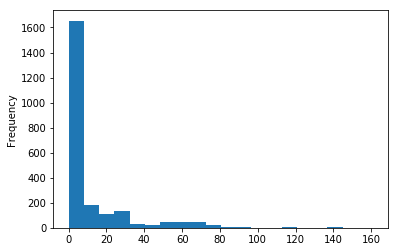

Firebird


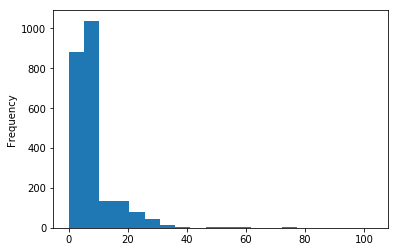

MonetDB


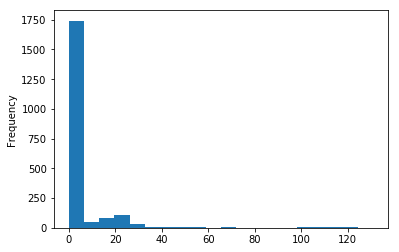

MS SQL Server


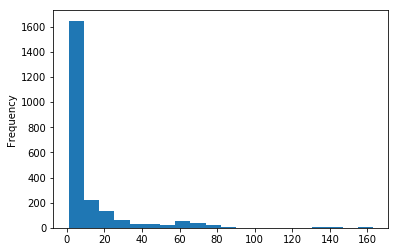

MariaDB


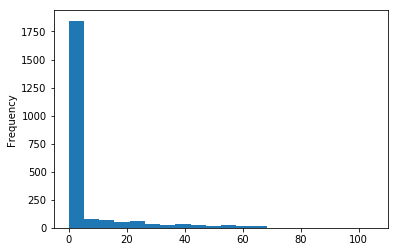

Oracle


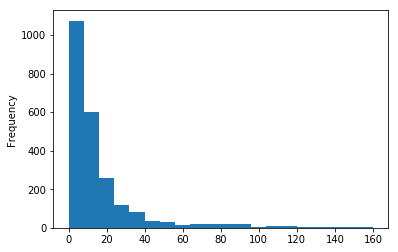

PostgreSQL


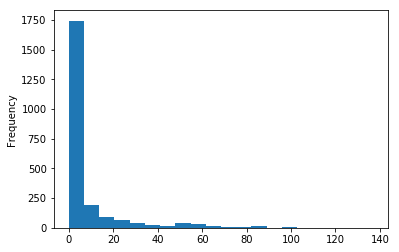

SQLite


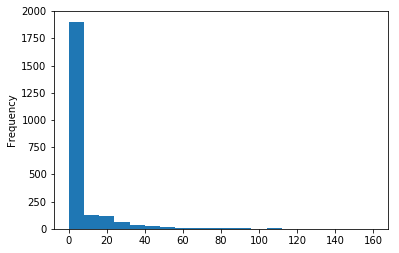

Teradata


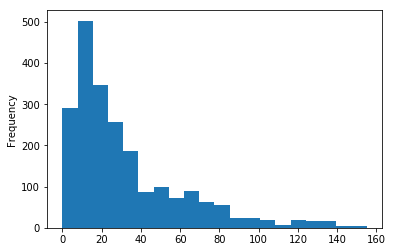

In [44]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
